This implementation requires Tensorflow 2.1.0, if you set up the environment using the `environment.yml` file, you should be good.

In [0]:
# Run only if you are using Google Colab
%pip install tensorflow==2.1.0
!pip install pyyaml h5py

In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

Getting Dataset


In [1]:
downloadDataSet = False

In [0]:
# Ensuring dataset is available
if downloadDataset:
    _URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    path_to_zip = tf.keras.utils.get_file('tiny-imagenet-200.zip', origin=_URL, extract=True)
    PATH = os.path.join(os.path.dirname(path_to_zip), 'tiny-imagenet-200')
else:
    PATH = "./tiny-imagenet-200"

In [0]:
# to access the dataset
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [0]:
# to save the model
checkpoint_path = "tinynet.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

Parameters

In [0]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
total_epochs = 60
batch_size = 256
input_shape = (64, 64, 3)
num_classes = 200

Utilities

In [0]:
# callback function to be used during training
def model_callbacks(path):
    # saving the model when validation accuracy increases after an epoch
    checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor = 'val_categorical_accuracy',
                                mode = 'max', save_best_only = True, verbose = 1)
    
    # reducing the learning rate when validation loss saturates or starts increasing 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor = 0.1,    
                                  patience = 8, verbose = 1, min_lr = 0.0001)
    
    return [checkpoint, reduce_lr]

In [0]:
# to print 5 of the augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# to plot the results of training - loss, top 1 accuracy and top 5 accuracy
def plot_graph(model, N):
    # loss plot
    plt.figure(0)
    plt.plot(np.arange(0, N), model.history['loss'], label='Training loss')
    plt.plot(np.arange(0, N), model.history['val_loss'], label='Testing loss')
    plt.title('Training vs Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # top 1 accuracy plot
    plt.figure(1)
    plt.plot(np.arange(0, N), model.history['categorical_accuracy'], label='Top 1 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_categorical_accuracy'], label='Top 1 Testing Accuracy')
    plt.title('Top 1 Training vs Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # top 5 accuracy plot
    plt.figure(2)
    plt.plot(np.arange(0, N), model.history['top_k_categorical_accuracy'], label='Top 5 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_top_k_categorical_accuracy'], label='Top 5 Testing Accuracy')
    plt.title('Top 5 Training vs Testing Acuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

Augmentation

In [0]:
# augmenting function with a validation split of 20.00 %
augment = tf.keras.preprocessing.image.ImageDataGenerator(zca_whitening=True, horizontal_flip=True, validation_split = 0.2)

# zca_whitening parameters
augment.mean = 112.69858580973307
augment.std = 70.93752549462194
augment.principal_components = 40

In [0]:
# generating augmented train data
train_data_gen = augment.flow_from_directory(batch_size=batch_size, directory=train_dir,
                                             shuffle=True, target_size=(64, 64),
                                             class_mode='categorical', subset='training')

# generating augmented validation data
val_data_gen = augment.flow_from_directory(batch_size=batch_size, directory = train_dir,
                                              shuffle=True, target_size=(64, 64),
                                              class_mode='categorical', subset = 'validation')

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


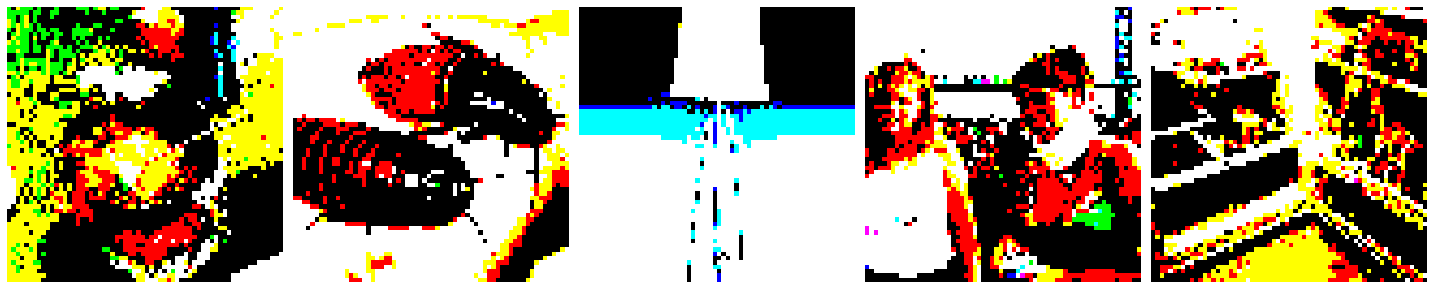

In [0]:
# printing 5 augmented images from training set
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

Model

In [0]:
# tinynet architecture
def build(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # convolution layer 1
    model.add(tf.keras.layers.Convolution2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
    
    # convolution layer 2
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
    
    # convolution layer 3
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 4
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))

    # convolution layer 5
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 6
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 7
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # flattening
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))

    # fully connected layer 1
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu')) 
    model.add(tf.keras.layers.Dropout(0.5))
    
    # fully connected layer 2
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

In [0]:
# summary of the architecture
build(input_shape, num_classes).summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization_180 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
activation_180 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_60 (ZeroPaddi (None, 66, 66, 64)        0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_181 (Bat (None, 22, 22, 128)     

Training

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization_81 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_81 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 66, 66, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_82 (Batc (None, 22, 22, 128)      

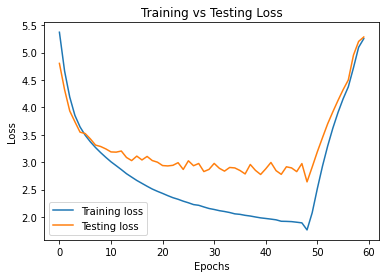

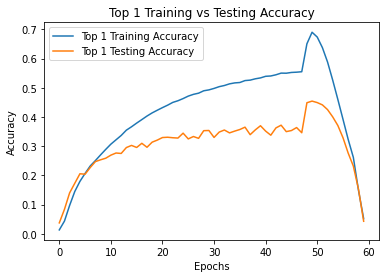

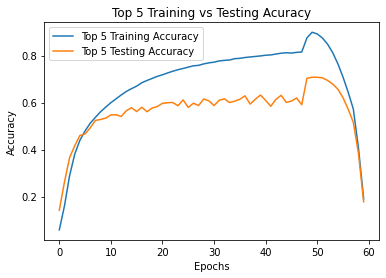

In [0]:
# initializing the model
model_tinynet = build(input_shape, num_classes)
model_tinynet.compile(optimizer=tfa.optimizers.weight_decay_optimizers.SGDW(
                        learning_rate=learning_rate, momentum=momentum, 
                        weight_decay=weight_decay, nesterov=True, name='SGDW'),
                        loss='categorical_crossentropy', 
                        metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

# traing the model
history = model_tinynet.fit(train_data_gen, epochs = total_epochs,
                            validation_data=val_data_gen, verbose=1, 
                            callbacks=model_callbacks(checkpoint_path))

# plotting the results
plot_graph(history, total_epochs)